<a href="https://colab.research.google.com/github/amanim7md/Happy-Sad-ClassificationAiModel/blob/main/Detecting_Happy_and_Sad_Faces_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install h5py

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sad-and-happy-face-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3105538%2F5348785%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240505%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240505T213622Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1afd6c698b8fb3ad2aacf725175ce1414ed9bf614dcfe177e5af49b8d883c9dbf271881f01c34f7f7c1e7c4f2b084a3c0f503e25d735d7492a4d3302bebd924b7fed25ab539a5f24677551c88edfb08b78bc94fdaf1443ee873183b4ac60907592a84ced5020e4050d3846e870e1262cf0c757773438905df388149928ffb577095bc03c874a5f719ba22ecd51f6170788a10b52fd738d29daa99ad93c27236c0f3791a42c4edcc21f95514fbb4ec670d838fc5d5abad44f2c69ca121e4b54dc6dc6ae38c3f09f9b282decbf44a194d9385891119ede7ccac3bb54758a441bac7b83f17b9b5affba2ad78ff69f1167323c9829117f4083c55ae89ff18b2a5eeb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 233086881 bytes downloaded
Downloaded and uncompressed: sad-and-happy-face-detection
Data source import complete.


<div style="background-color:#FFFFF; padding:20px;">
    <Center><h1 style="color:#FF7F50;">Image Classification for Sad and Happy Faces</h1></center>
</div>

In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib as mp
import cv2
import imghdr
import os
import numpy as np
from matplotlib import pyplot as plt

<font color='#008080'><b>Loading Data</b></font>

In [4]:
data_dir = 'data'

<font color='#008080'><b>Image Extensions</b></font>

In [5]:
image_exts = ['jpeg' , 'jpg' ,'bmp' , 'png']

<font color='#008080'><b>Listing Directory Contents</b></font>

In [6]:
os.listdir('/kaggle/input/sad-and-happy-face-detection/data')

['happy', 'sad']

<font color='#008080'><b>Filtering Images by Extension</b></font>

In [7]:
data_dir = '/kaggle/input/sad-and-happy-face-detection/data'
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

<font color='#008080'><b>Creating Image Dataset</b></font>

In [8]:
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/sad-and-happy-face-detection/data')


Found 1988 files belonging to 2 classes.


<font color='#008080'><b>Creating Data Iterator</b></font>

In [9]:
data_iterator = data.as_numpy_iterator()

<font color='#008080'><b>Getting a Batch of Data</b></font>

In [10]:
batch = data_iterator.next()

<font color='#008080'><b>Displaying a Selection of Images</b></font>

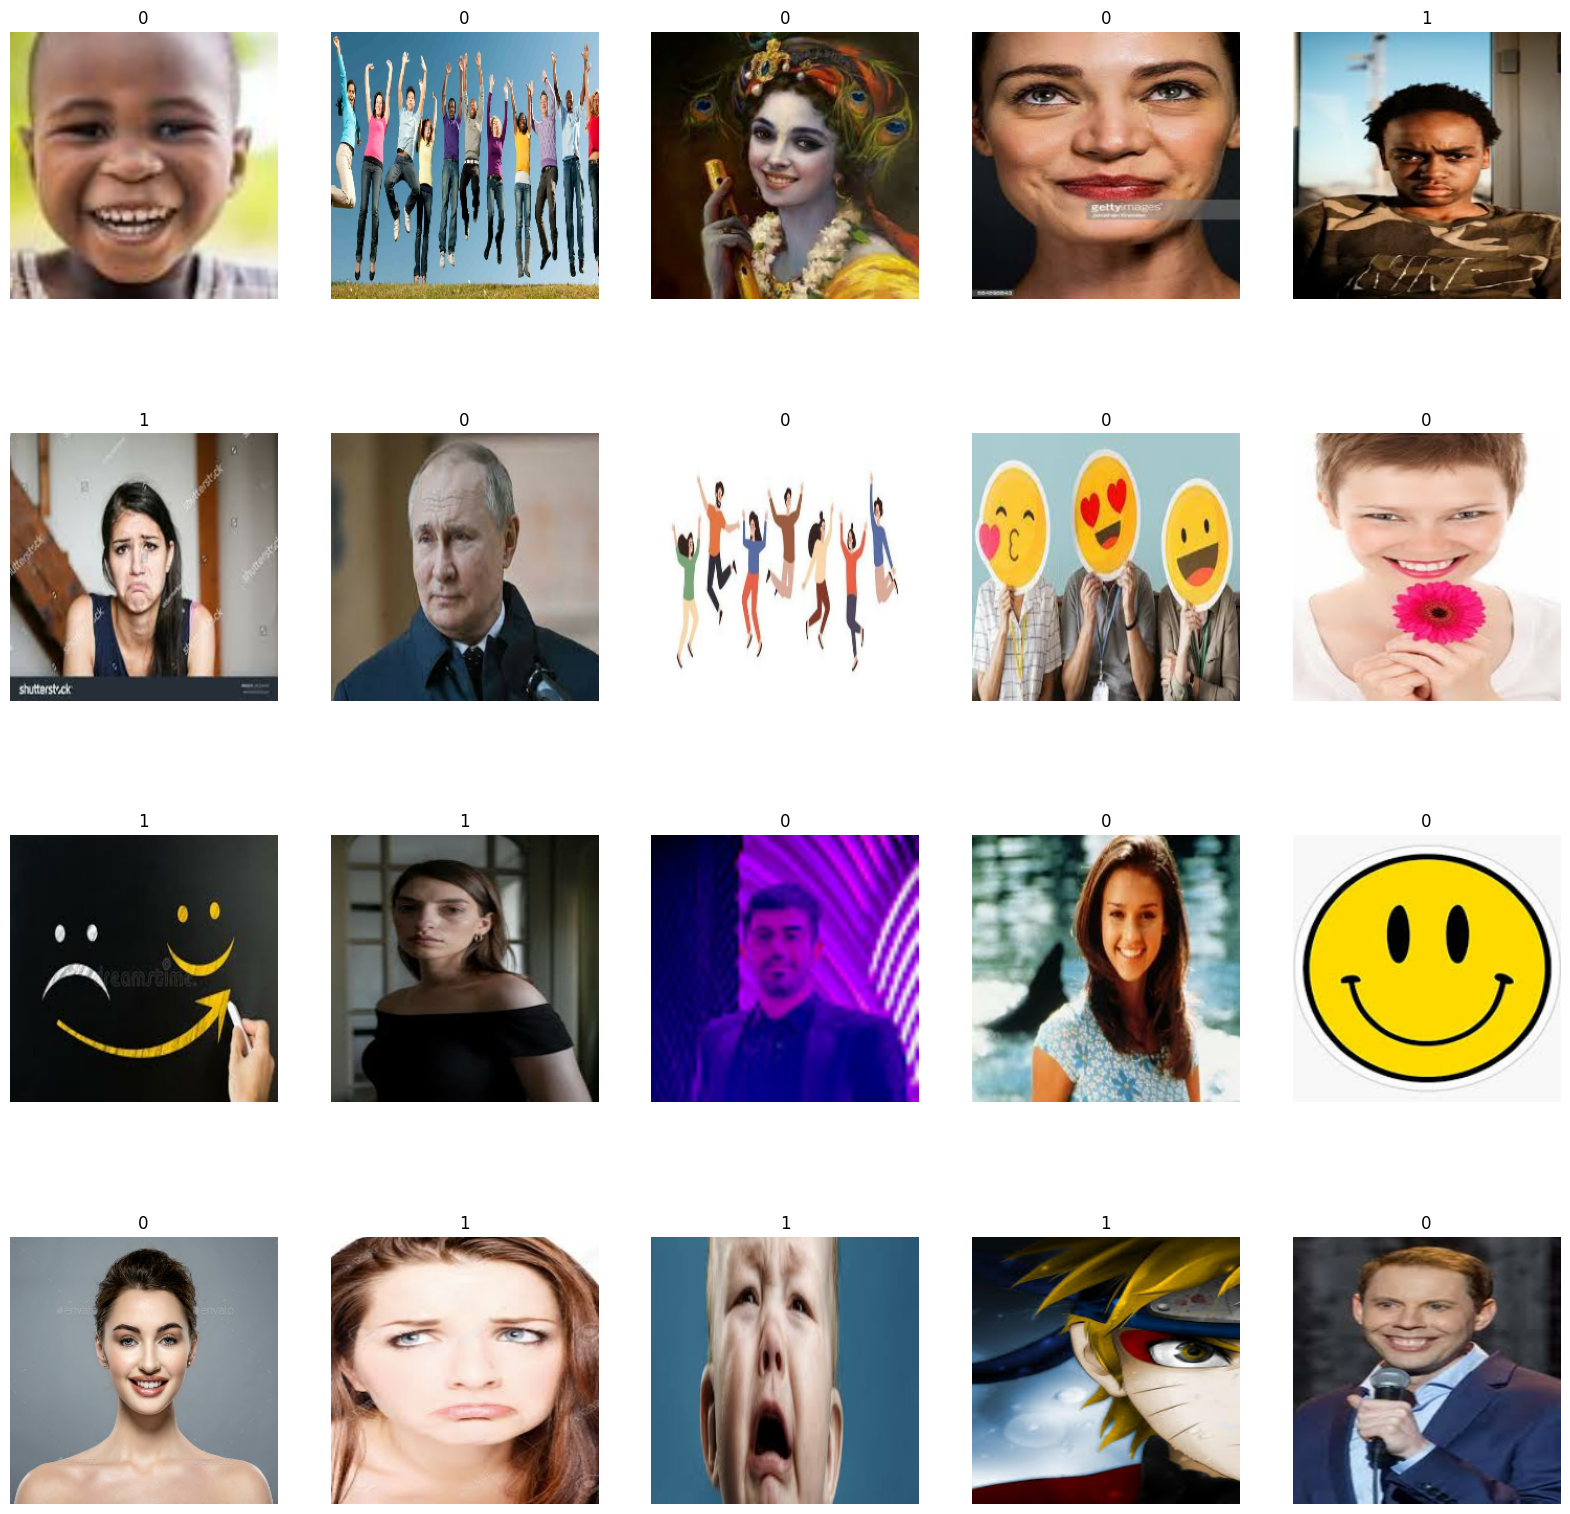

In [11]:
fig, ax = plt.subplots(ncols=5, nrows=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:20]):
    ax[idx//5, idx%5].imshow(img.astype(int))
    ax[idx//5, idx%5].title.set_text(batch[1][idx])
    ax[idx//5, idx%5].axis('off')

<font color='#008080'><b>Applying Normalization to Image Data</b></font>

In [12]:
data = data.map(lambda x,y: (x/255,y))

<font color='#008080'><b>Converting Data to Numpy Array</b></font>

In [13]:
data.as_numpy_iterator().next()


(array([[[[0.11764706, 0.12156863, 0.10196079],
          [0.11764706, 0.12156863, 0.10196079],
          [0.11764706, 0.11841299, 0.10827206],
          ...,
          [0.12873775, 0.12873775, 0.12873775],
          [0.12267157, 0.12267157, 0.12267157],
          [0.21960784, 0.21960784, 0.21960784]],
 
         [[0.04790135, 0.05182292, 0.03943015],
          [0.04790135, 0.05182292, 0.03943015],
          [0.04790135, 0.04866728, 0.04187084],
          ...,
          [0.05946176, 0.05946176, 0.05946176],
          [0.05504904, 0.05504904, 0.05504904],
          [0.14986213, 0.14986213, 0.14986213]],
 
         [[0.00531556, 0.00923713, 0.        ],
          [0.00531556, 0.00923713, 0.        ],
          [0.00531556, 0.00608149, 0.        ],
          ...,
          [0.01577819, 0.01577819, 0.01577819],
          [0.01240809, 0.01240809, 0.01240809],
          [0.10588235, 0.10588235, 0.10588235]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

<font color='#008080'><b>Splitting the Data into Train, Validation, and Test Sets</b></font>

In [14]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

<font color='#008080'><b>Splitting the Data into Train, Validation, and Test Sets</b></font>

In [15]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

<font color='#008080'><b>Importing Required Modules</b></font>

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D , Dense , Flatten , Dropout

<font color='#008080'><b>Creating a Sequential Model</b></font>

In [17]:
model = Sequential()

<font color='#008080'><b>Building the Convolutional Neural Network (CNN) Architecture</b></font>

In [18]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

<font color='#008080'><b>Compiling the Model</b></font>

In [19]:
model.compile('adam',loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

<font color='#008080'><b>Model Summary</b></font>

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

<font color='#008080'><b>Setting up Logging Directory</b></font>

In [21]:
logdir = 'logs'

<font color='#008080'><b>Setting up TensorBoard Callback</b></font>

In [22]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

<font color='#008080'><b>Training the Model</b></font>

In [23]:
hist = model.fit(train,epochs=30,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/30
44/44 [==============================] - 23s 368ms/step - loss: 0.7549 - accuracy: 0.5320 - val_loss: 0.6806 - val_accuracy: 0.5182
Epoch 2/30
44/44 [==============================] - 18s 384ms/step - loss: 0.6632 - accuracy: 0.5724 - val_loss: 0.6612 - val_accuracy: 0.6042
Epoch 3/30
44/44 [==============================] - 17s 379ms/step - loss: 0.6349 - accuracy: 0.6449 - val_loss: 0.6387 - val_accuracy: 0.6354
Epoch 4/30
44/44 [==============================] - 18s 385ms/step - loss: 0.5528 - accuracy: 0.7166 - val_loss: 0.6306 - val_accuracy: 0.6484
Epoch 5/30
44/44 [==============================] - 19s 408ms/step - loss: 0.4255 - accuracy: 0.7926 - val_loss: 0.6584 - val_accuracy: 0.7005
Epoch 6/30
44/44 [==============================] - 20s 431ms/step - loss: 0.3394 - accuracy: 0.8665 - val_loss: 0.6731 - val_accuracy: 0.6823
Epoch 7/30
44/44 [==============================] - 16s 358ms/step - loss: 0.2499 - accuracy: 0.8999 - val_loss: 0.6186 - val_accuracy: 0.7578

<font color='#008080'><b>Plotting Loss</b></font>

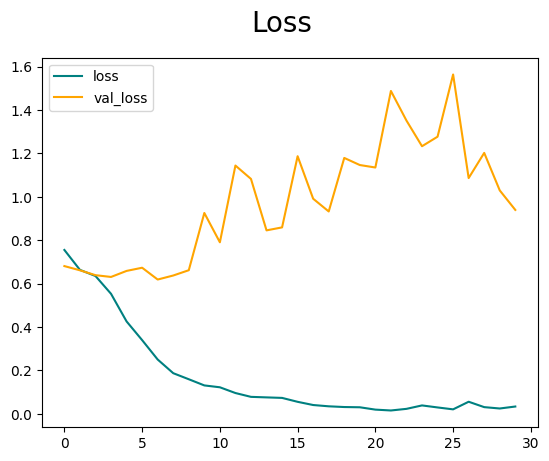

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

<font color='#008080'><b>Plotting Accuracy</b></font>

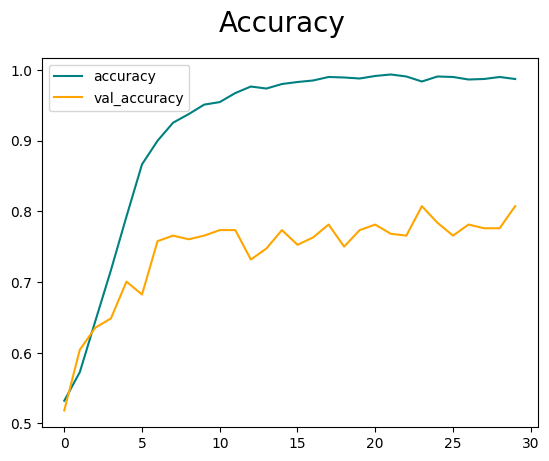

In [25]:
fig = plt.figure()
plt.plot(hist.history['accuracy'] , color ='teal' , label ='accuracy')
plt.plot(hist.history['val_accuracy'], color ='orange' , label = 'val_accuracy')
fig.suptitle('Accuracy' , fontsize =20)
plt.legend(loc="upper left")
plt.show()

<font color='#008080'><b>Importing Metrics</b></font>

In [26]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

<font color='#008080'><b>Initializing Metrics</b></font>

In [27]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

<font color='#008080'><b>Evaluating Metrics</b></font>

In [28]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 31ms/step


<font color='#008080'><b>Printing Metric Results</b></font>

In [29]:
print(pre.result(), re.result(),acc.result())

tf.Tensor(0.73333335, shape=(), dtype=float32) tf.Tensor(0.7938144, shape=(), dtype=float32) tf.Tensor(0.75, shape=(), dtype=float32)


<font color='#008080'><b>Displaying an Image</b></font>

<function matplotlib.pyplot.show(close=None, block=None)>

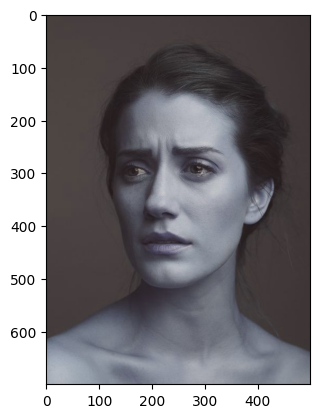

In [30]:
img = cv2.imread('/kaggle/input/sad-and-happy-face-detection/666.jpg')
plt.imshow(img)
plt.show

<font color='#008080'><b>Resizing and Displaying an Image</b></font>

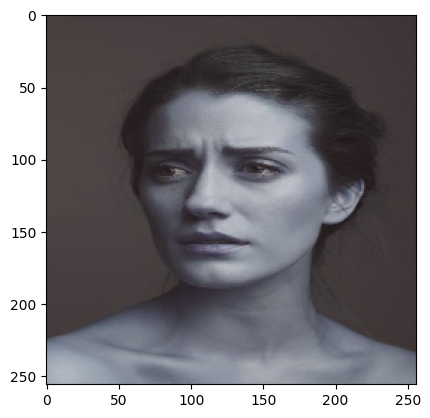

In [31]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

<font color='#008080'><b>Performing Inference on Resized Image</b></font>



In [32]:
yhat = model.predict(np.expand_dims(resize/255,0))


1/1 [==============================] - 0s 253ms/step


<font color='#008080'><b>Predicted Output</b></font>

In [33]:
yhat

array([[0.95681995]], dtype=float32)

<font color='#008080'><b>Predicted Class</b></font>

In [34]:
if yhat > 0.5:
    print (f'Predicted Class is Sad Face')
else:
    print (f'Predicted Class is Happy Face')

Predicted Class is Sad Face


<font color='#008080'><b>Loading a Saved Model</b></font>

In [35]:
from tensorflow.keras.models import load_model

<font color='#008080'><b>Saving a Trained Model</b></font>

In [36]:
model.save(os.path.join('imageclassifier.h5'))


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
new_model = load_model('imageclassifier.h5')

In [38]:
new_model.predict(np.expand_dims(resize/255,0))


1/1 [==============================] - 0s 73ms/step


array([[0.95681995]], dtype=float32)

In [39]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# تحميل النموذج المدرب
model = load_model('imageclassifier.h5')

# تهيئة الكاميرا
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("لا يمكن التقاط الصورة")
        break

    # تغيير حجم الصورة إلى الحجم المتوقع من النموذج
    resized_frame = cv2.resize(frame, (256, 256))
    # تغيير تنسيق الصورة إلى تنسيق RGB
    resized_frame_rgb = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    # تحويل الصورة إلى مصفوفة numpy
    image_array = np.array(resized_frame_rgb) / 255.0
    # توسيع الأبعاد لتناسب الشكل المتوقع للنموذج
    image_array_expanded = np.expand_dims(image_array, axis=0)

    # تحليل المشاعر باستخدام النموذج
    prediction = model.predict(image_array_expanded)

    # تحديد النص الذي سيتم عرضه على الإطار بناءً على النتيجة
    if prediction > 0.5:
        text = "Sad Face"
    else:
        text = "Happy Face"

    # عرض النتيجة على الإطار
    cv2.putText(frame, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # عرض الإطار
    cv2.imshow('Emotion Detection', frame)

    # انتظار الضغط على مفتاح 'q' لإنهاء البرنامج
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# إغلاق الكاميرا وإغلاق النافذة
cap.release()
cv2.destroyAllWindows()


لا يمكن التقاط الصورة


In [40]:
from tensorflow.keras.models import load_model


model = load_model('imageclassifier.h5')

# حفظ النموذج كملف H5
model.save('converted_model.h5')



In [41]:
# تنزيل الملف من Google Colab
from google.colab import files
files.download('converted_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
from flask import Flask, request, render_template
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import os

app = Flask(__name__)

# Load the trained model
model = load_model('imageclassifier.h5')

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    # Check if a file was uploaded
    if 'file' not in request.files:
        return render_template('index.html', message='No file part')

    file = request.files['file']

    # If the user does not select a file, the browser submits an empty file without a filename
    if file.filename == '':
        return render_template('index.html', message='No selected file')

    if file:
        # Save the uploaded file
        filename = file.filename
        file_path = os.path.join('uploads', filename)
        file.save(file_path)

        # Read the uploaded image
        img = cv2.imread(file_path)

        # Resize the image to the expected size by the model
        resized_img = cv2.resize(img, (256, 256))

        # Convert the image to RGB format and normalize
        resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        resized_img_norm = resized_img_rgb / 255.0

        # Expand dimensions to match the expected input shape of the model
        image_array_expanded = np.expand_dims(resized_img_norm, axis=0)

        # Perform inference using the loaded model
        prediction = model.predict(image_array_expanded)

        # Determine the predicted class
        if prediction > 0.5:
            predicted_class = "Sad Face"
        else:
            predicted_class = "Happy Face"

        # Render the result on the webpage
        return render_template('index.html', message='Prediction: ' + predicted_class, image_path=file_path)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [45]:
!pip install fastapi uvicorn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [62]:
import uvicorn
from fastapi import FastAPI, File, UploadFile, BackgroundTasks
from tensorflow.keras.models import load_model
import cv2
import numpy as np

app = FastAPI()

model = load_model('imageclassifier.h5')

def predict_emotion(image_array):
    # Analyze emotion using the model
    prediction = model.predict(np.expand_dims(image_array, axis=0))
    return prediction[0][0]

@app.post("/uploadfile/")
async def create_upload_file(background_tasks: BackgroundTasks, file: UploadFile = File(...)):
    contents = await file.read()
    nparr = np.frombuffer(contents, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    # Resize the image to the expected size by the model
    resized_img = cv2.resize(img, (256, 256))
    # Convert the image to numpy array
    image

In [63]:
from fastapi import FastAPI, File, UploadFile
import uvicorn
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import io

# Load the trained model
model = load_model('imageclassifier.h5')

# Initialize the FastAPI app
app = FastAPI()

# Define a route to handle image uploads
@app.post("/upload/")
async def predict_emotion(file: UploadFile = File(...)):
    # Read image file
    contents = await file.read()
    image_stream = io.BytesIO(contents)
    image = Image.open(image_stream)

    # Preprocess the image
    image = np.array(image)[:, :, :3]  # Remove alpha channel if present
    image = cv2.resize(image, (256, 256))  # Resize image to expected shape
    image = image / 255.0  # Normalize image

    # Perform inference
    prediction = model.predict(np.expand_dims(image, axis=0))

    # Determine emotion label
    emotion = "Sad Face" if prediction > 0.5 else "Happy Face"

    return {"emotion": emotion}

# Run the FastAPI app
if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)


RuntimeError: asyncio.run() cannot be called from a running event loop

In [64]:
from fastapi import FastAPI, File, UploadFile
import uvicorn
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import io

# Load the trained model
model = load_model('imageclassifier.h5')

# Initialize the FastAPI app
app = FastAPI()

# Define a route to handle image uploads
@app.post("/upload/")
async def predict_emotion(file: UploadFile = File(...)):
    # Read image file
    contents = await file.read()
    image_stream = io.BytesIO(contents)
    image = Image.open(image_stream)

    # Preprocess the image
    image = np.array(image)[:, :, :3]  # Remove alpha channel if present
    image = cv2.resize(image, (256, 256))  # Resize image to expected shape
    image = image / 255.0  # Normalize image

    # Perform inference
    prediction = model.predict(np.expand_dims(image, axis=0))

    # Determine emotion label
    emotion = "Sad Face" if prediction > 0.5 else "Happy Face"

    return {"emotion": emotion}

# Run the FastAPI app
uvicorn.run(app, host="0.0.0.0", port=8000)

RuntimeError: asyncio.run() cannot be called from a running event loop

In [65]:
# Run the FastAPI app
app.run(host="0.0.0.0", port=8000)

AttributeError: 'FastAPI' object has no attribute 'run'

In [66]:
import uvicorn

# ... (rest of your code)

# Run the FastAPI app using uvicorn
if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)

RuntimeError: asyncio.run() cannot be called from a running event loop